In [1]:
import pandas as pd
from os.path import join, dirname, basename
import os
import numpy as np
from icecream import ic

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
top_n = 6

In [3]:
indir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var/variants.init_knnRes.30_objs_standard/aggregate/annotation/"
outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var/variants.init_knnRes.30_objs_standard/aggregate/annotation/clone_lineage"


In [4]:
cells_meta = pd.read_csv(join(indir, "se_cells_meta.tsv"), sep="\t")
cells_meta

cells_meta = cells_meta[~(cells_meta["run"].isnull())]
cells_meta["run"].unique()



array(['cd34norm', 'CHIP_a1', 'CHIP_b1', 'CHIP_b2'], dtype=object)

## Plot lineage distribution

In [5]:
cells_meta.columns

Index(['orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'total', 'duplicate',
       'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters',
       'cell_id', 'is__cell_barcode', 'TSS_fragments',
       'DNase_sensitive_region_fragments', 'enhancer_region_fragments',
       'promoter_region_fragments', 'on_target_fragments',
       'blacklist_region_fragments', 'peak_region_fragments',
       'peak_region_cutsites', 'proj', 'expID', 'nucleosome_signal',
       'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile',
       'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group',
       'ATAC_snn_res.0.8', 'seurat_clusters', 'nCount_ATAC_log2', 'nCount_RNA',
       'nFeature_RNA', 'Row.names', 'name', 'run', 'donor', 'condition'],
      dtype='object')

In [6]:
donor_run_meta = cells_meta.loc[~cells_meta[["run", "donor"]].duplicated(), ["run", "donor"]].set_index("donor")
donor_run_meta

,run
donor,
cd34norm_1,cd34norm
cd34norm_2,cd34norm
cd34norm_3,cd34norm
cd34norm_0,cd34norm
CHIP_a1_1,CHIP_a1
CHIP_a1_4,CHIP_a1
CHIP_a1_3,CHIP_a1
CHIP_a1_0,CHIP_a1
CHIP_a1_2,CHIP_a1


In [7]:
clones_df = cells_meta.groupby(["seurat_clusters", "donor", "name", "run"]).size().reset_index().rename({0:"ncells"}, axis=1)
clones_df

clust_order = clones_df.groupby("seurat_clusters").sum().sort_values("ncells")[::-1].index
clust_order

Int64Index([1, 0, 2, 3, 7, 4, 5, 6, 10, 8, 9, 13, 11, 14, 16, 12, 15, 17, 18], dtype='int64', name='seurat_clusters')

In [8]:
(clones_df["ncells"]<0).any()

False

In [9]:
don_ncells = clones_df.groupby(["donor"]).sum()["ncells"]
don_ncells

clones_df["donor_normed_ncells"] = clones_df.apply(lambda x: x["ncells"]/don_ncells.loc[x["donor"]], axis=1)
clones_df = clones_df.sort_values(["ncells", "donor_normed_ncells"])[::-1]
clones_df

,seurat_clusters,donor,name,run,ncells,donor_normed_ncells
220,0,cd34norm_3,cd34norm_3_0,cd34norm,134,0.067745
652,2,cd34norm_1,cd34norm_1_0,cd34norm,115,0.068412
343,1,CHIP_b1_1,CHIP_b1_1_2,CHIP_b1,107,0.059280
645,2,cd34norm_0,cd34norm_0_0,cd34norm,98,0.156550
930,3,cd34norm_3,cd34norm_3_0,cd34norm,98,0.049545
...,...,...,...,...,...,...
2056,9,CHIP_b1_0,CHIP_b1_0_31,CHIP_b1,1,0.000373
2050,9,CHIP_b1_0,CHIP_b1_0_23,CHIP_b1,1,0.000373
2048,9,CHIP_b1_0,CHIP_b1_0_21,CHIP_b1,1,0.000373
1293,5,CHIP_b1_0,CHIP_b1_0_21,CHIP_b1,1,0.000373


In [10]:
clones_df.groupby(["donor", "seurat_clusters"]).sum()[["ncells"]]

ncells
donor      seurat_clusters        
CHIP_a1_0  0                    93
           1                     2
           2                    62
           3                    53
           4                    44
...                            ...
cd34norm_3 13                    4
           14                   56
           15                   37
           16                   29
           17                   13

[220 rows x 1 columns]

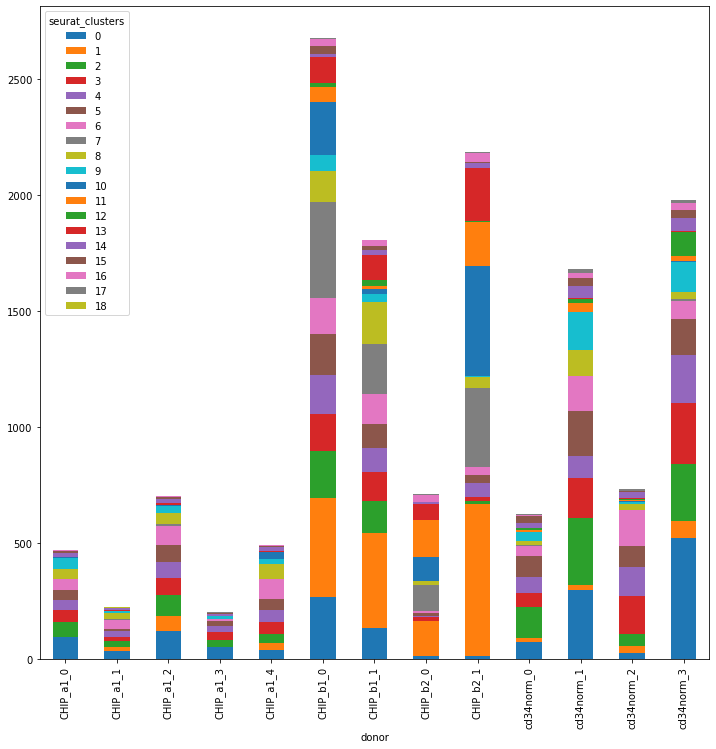

In [11]:
f, ax = plt.subplots(figsize=(12,12))
don_clust_counts = clones_df.groupby(["donor", "seurat_clusters"]).sum()[["ncells"]].reset_index()
don_clust_counts.pivot(index="donor", values="ncells",
                       columns="seurat_clusters").fillna(0).plot.bar(stacked=True, ax=ax)
plt.savefig(join(outdir, "donor_lineage_clusters.svg"))
plt.savefig(join(outdir, "donor_lineage_clusters.pdf"))

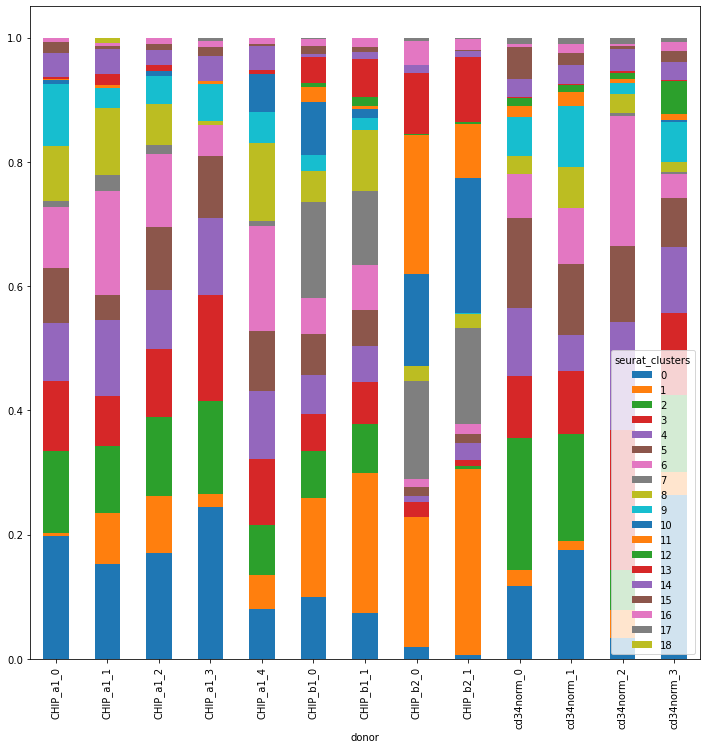

In [12]:
f, ax = plt.subplots(figsize=(12,12))
don_clust_counts = clones_df.groupby(["donor", "seurat_clusters"]).sum()[["donor_normed_ncells"]].reset_index()
don_clust_counts.pivot(index="donor", values="donor_normed_ncells",
                       columns="seurat_clusters").fillna(0).plot.bar(stacked=True, ax=ax)
plt.savefig(join(outdir, "donor_lineage_clusters_normed.svg"))
plt.savefig(join(outdir, "donor_lineage_clusters_normed.pdf"))

In [13]:
clones_df.groupby("donor").sum()[["donor_normed_ncells"]]

,donor_normed_ncells
donor,
CHIP_a1_0,1.0
CHIP_a1_1,1.0
CHIP_a1_2,1.0
CHIP_a1_3,1.0
CHIP_a1_4,1.0
CHIP_b1_0,1.0
CHIP_b1_1,1.0
CHIP_b2_0,1.0
CHIP_b2_1,1.0


In [14]:
def plots(df, y_col, outdir):
    sns.catplot(x="seurat_clusters", y=y_col, data=clones_df, hue="run", height=8,
                row="donor", kind="boxen", )
    plt.savefig(join(outdir, "clone_cluster_boxen.svg"))
    plt.savefig(join(outdir, "clone_cluster_boxen.pdf"))
    
    sns.catplot(x="seurat_clusters", y=y_col, data=clones_df, hue="run", 
                row="donor", kind="violin", inner = "stick", height=8)
    plt.savefig(join(outdir, "clone_cluster_violin.svg"))
    plt.savefig(join(outdir, "clone_cluster_violin.pdf"))
    
    sns.catplot(x="seurat_clusters", y=y_col, data=clones_df, hue="run", height=8,
                row="donor", kind="violin", inner = "stick", sharey=False)
    plt.savefig(join(outdir, "clone_cluster_violin_noShareY.svg"))
    plt.savefig(join(outdir, "clone_cluster_violin.noShareY.pdf"))
    
    sns.catplot(x="seurat_clusters", y=y_col, data=clones_df, hue="run", height=8,
                row="donor", kind="boxen", sharey=False)
    plt.savefig(join(outdir, "clone_cluster_boxen_noShareY.svg"))
    plt.savefig(join(outdir, "clone_cluster_boxen.noShareY.pdf"))
    #top_clones_plots(df, y_col, outdir)

    return


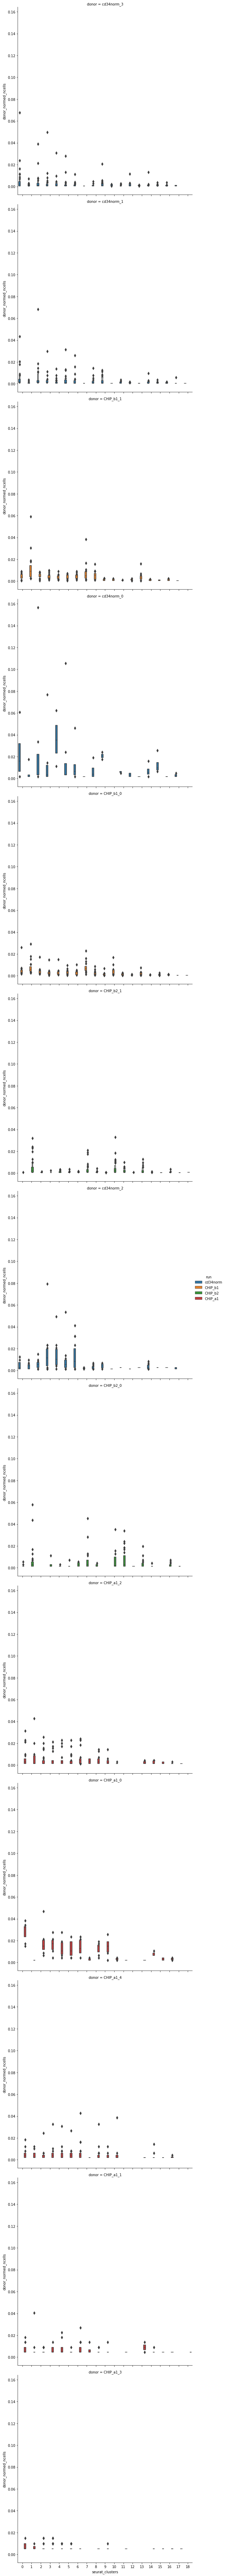

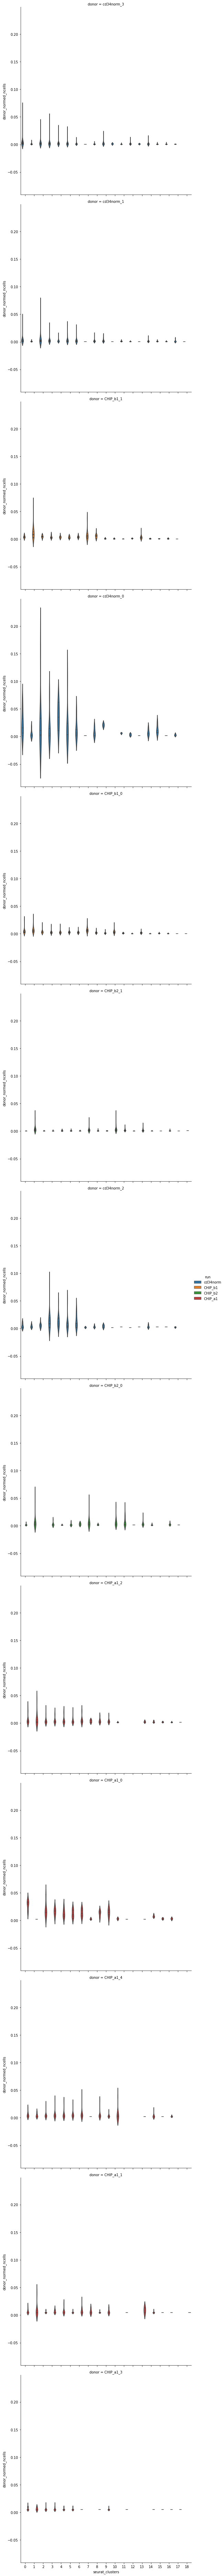

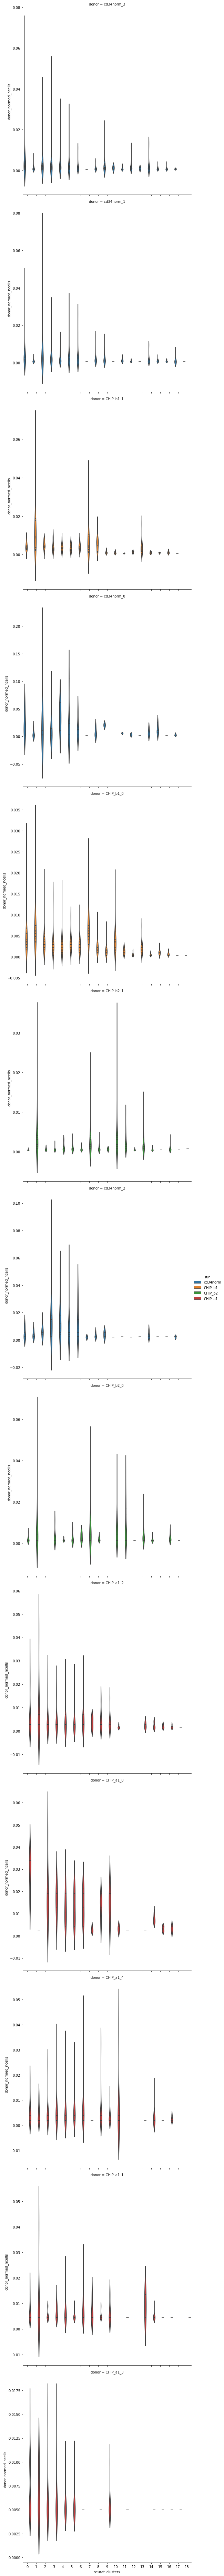

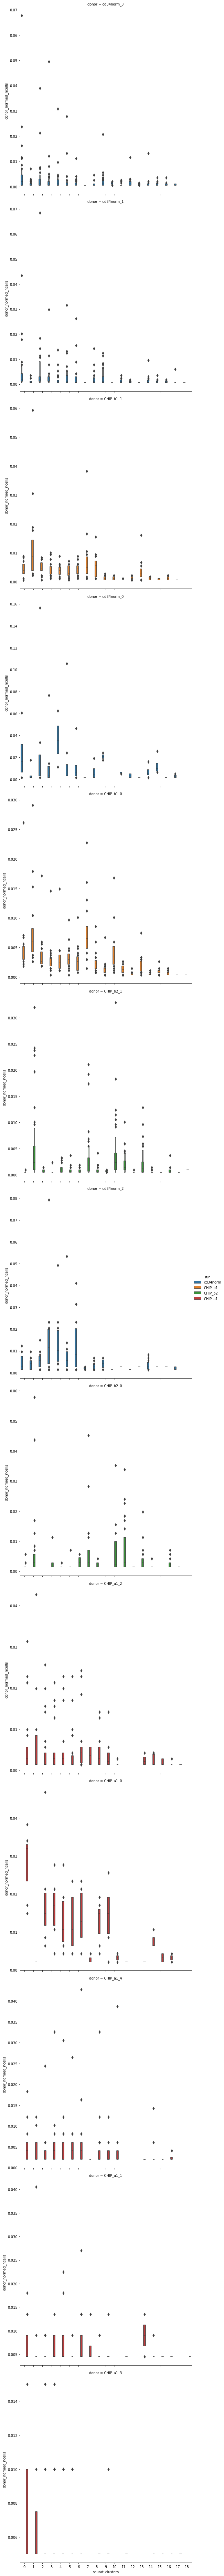

In [15]:
norm_outdir = join(outdir, "donor_normed_distributions")
if not os.path.exists(norm_outdir):
    os.mkdir(norm_outdir)
plots(clones_df, y_col="donor_normed_ncells", outdir=norm_outdir)

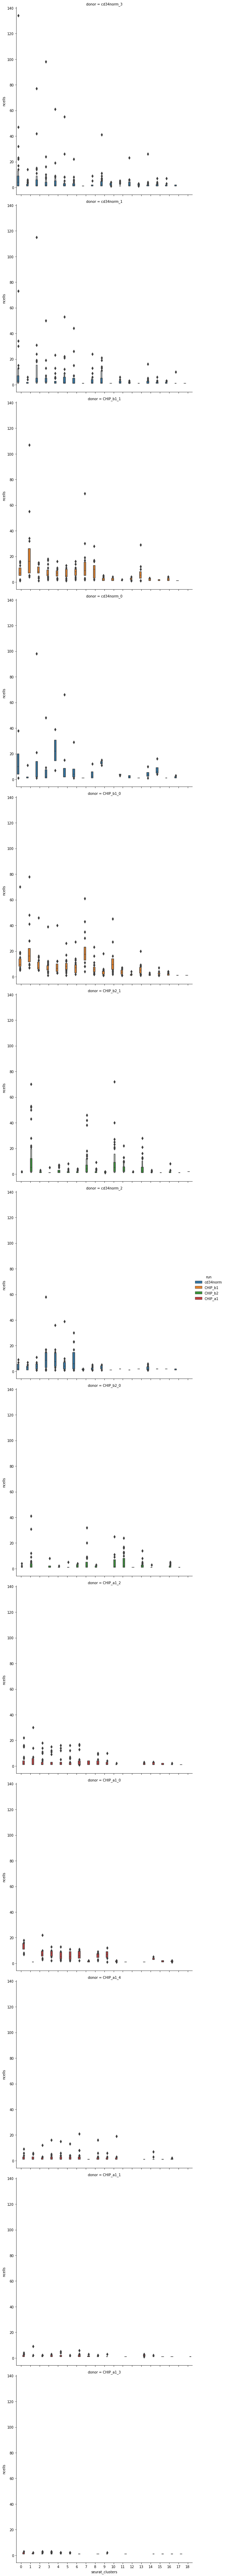

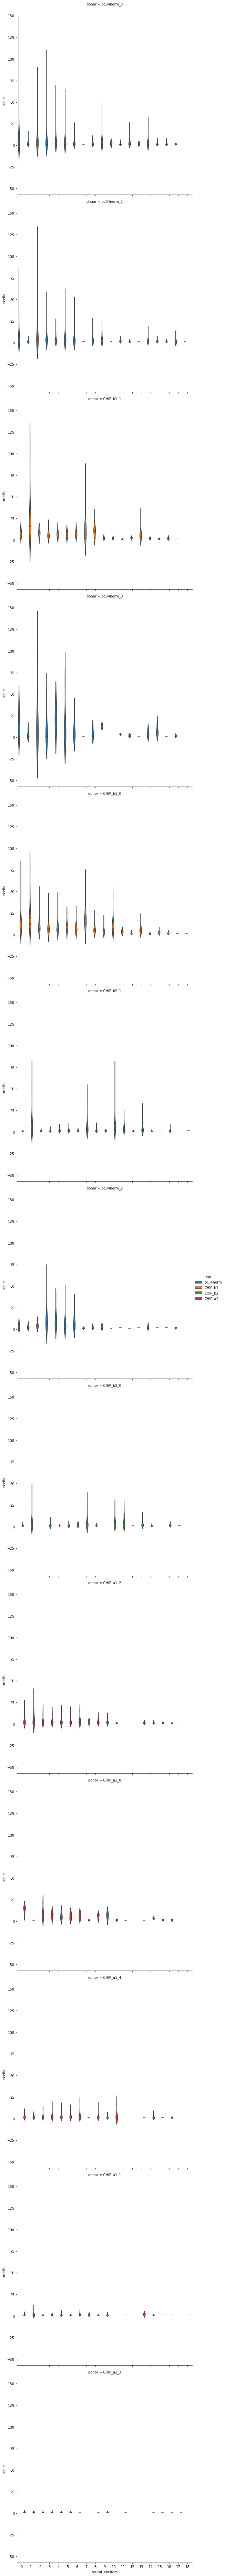

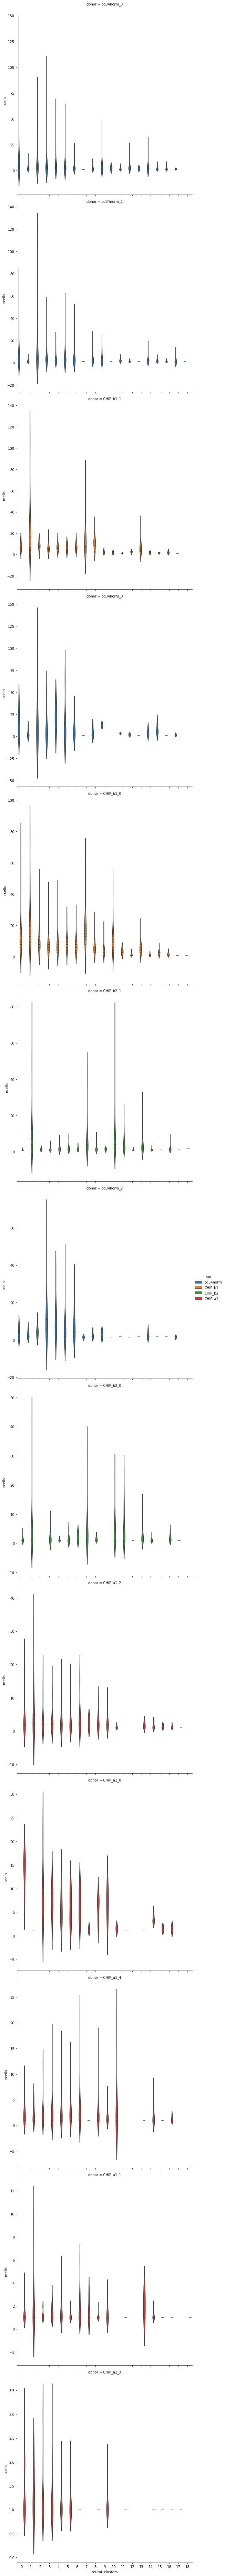

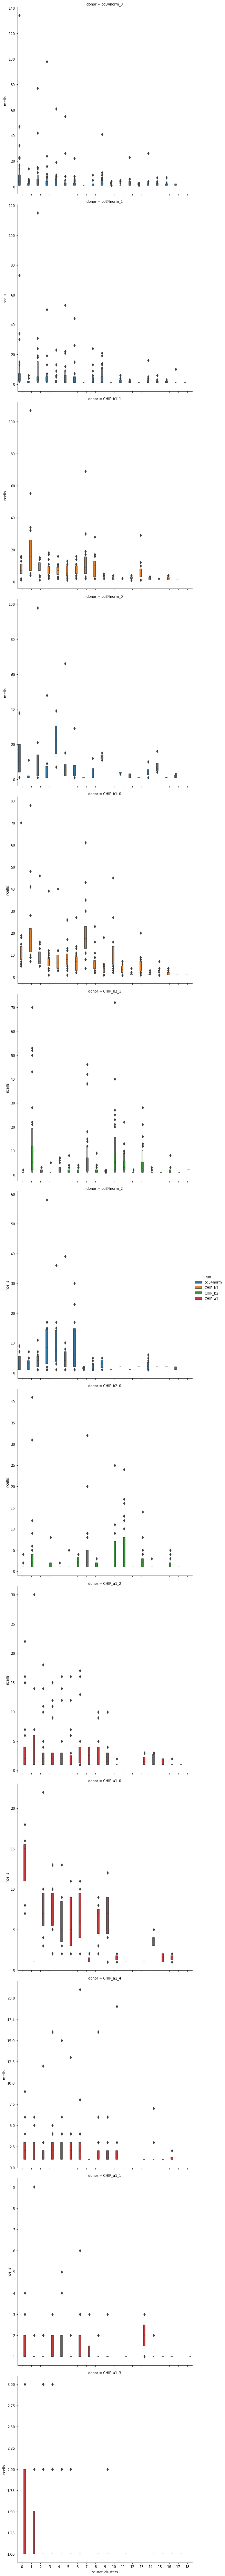

In [16]:
plots(clones_df, y_col="ncells", outdir=outdir)

## Run barplots for each donor separately for the top clones

In [17]:
clones_df = cells_meta.groupby(["seurat_clusters", "donor", "name", "run", "condition"]).size().reset_index().rename({0:"ncells"}, axis=1)
clust_order = clones_df.groupby("seurat_clusters").sum().sort_values("ncells")[::-1].index
for don, val in clones_df.groupby("donor"):
    top_vals = val.sort_values("ncells")[::-1][:top_n]
    sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
                sharex=True, sharey=False, 
                col="name", col_wrap=3, kind="bar", order=clust_order)
    plt.savefig(join(outdir, "topClones_across_lineage.pdf"))
    plt.savefig(join(outdir, "topClones_across_lineage.svg"))
    plt.close()
    
    sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
                sharex=False, sharey=False, 
                col="name", col_wrap=3, kind="bar", order=clust_order)
    plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.pdf"))
    plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.svg"))
    plt.close()

In [18]:
# sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
#             row="donor", kind="boxen", )
# plt.savefig(join(outdir, "clone_cluster_boxen.svg"))
# plt.savefig(join(outdir, "clone_cluster_boxen.pdf"))

# sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
#             row="donor", kind="box")
# plt.savefig(join(outdir, "clone_cluster_box.svg"))
# plt.savefig(join(outdir, "clone_cluster_box.pdf"))

# sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
#             row="donor", kind="box", sharey=False)
# plt.savefig(join(outdir, "clone_cluster_box_noShareY.svg"))
# plt.savefig(join(outdir, "clone_cluster_box.noShareY.pdf"))

# clones_df = cells_meta.groupby(["seurat_clusters", "donor", "name", "run", "condition"]).size().reset_index().rename({0:"ncells"}, axis=1)
# clust_order = clones_df.groupby("seurat_clusters").sum().sort_values("ncells")[::-1].index
# for don, val in clones_df.groupby("donor"):
#     top_vals = val.sort_values("ncells")[::-1][:top_n]
#     sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
#                 sharex=True, sharey=False, 
#                 col="name", col_wrap=3, kind="bar", order=clust_order)
#     plt.savefig(join(outdir, "topClones_across_lineage.pdf"))
#     plt.savefig(join(outdir, "topClones_across_lineage.svg"))
#     plt.close()
    
#     sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
#                 sharex=False, sharey=False, 
#                 col="name", col_wrap=3, kind="bar", order=clust_order)
#     plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.pdf"))
#     plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.svg"))
#     plt.close()